Diabetes preprocessed dataset. Use Scikit-Learn for train-test splitting and other metrics. 

Pytorch for implementation of NN. 

In [13]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#Set seed to make reproducible
torch.manual_seed(2024)

#Read in dataset
df = pd.read_csv("diabetes_preprocessed.csv")
# Separate features and target variable
X = df.drop(columns="Outcome").values  # 'Outcome' is the target variable
y = df["Outcome"].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for regression
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader 
training_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data= TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32 #Random, change this

train_loader = DataLoader(training_data, batch_size, shuffle=True) #Want to shuffle to prevent overfitting
test_loader = DataLoader(test_data, batch_size, shuffle=False)


In [14]:
#Define the architecture of our Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.leakyrelu = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.leakyrelu(self.fc1(x)) #First hidden layer
        x = self.leakyrelu(self.fc2(x))
        x = self.sigmoid(self.output(x)) #Output layer
        return x

In [15]:
input_size = X_train.shape[1]
hidden_size1 = 8
hidden_size2 = 16 #Random, change this
output_size = 1 #Regression

model = NeuralNet(input_size, hidden_size1, hidden_size2, output_size)

learning_rate = 0.0001

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)


In [16]:
def train_loop(dataloader, model, loss_function, optimizer):
    model.train()
    size = len(dataloader.dataset)
    all_predictions = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_function(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step() #Optimization
        optimizer.zero_grad() #Reset gradients

        # Collect predictions for residuals calculation later
        all_predictions.extend(pred.detach().cpu().numpy())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return np.array(all_predictions)


In [17]:
epochs = 500
for epoch in range(epochs):
    #print(f"Epoch {epoch+1}\n-------------------------------")
    predictions = train_loop(train_loader, model, loss_function, optimizer)
print("Done!")

c:\Users\justi\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\justi\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Done!


Accuracy using Combined Model: 79.2%


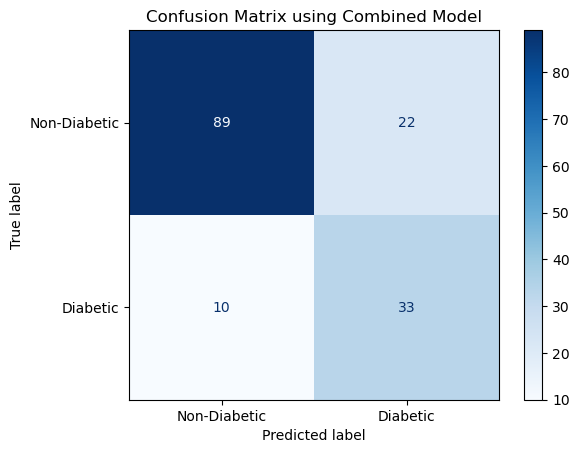

In [18]:
#Create residuals
y_train = y_train.flatten()
predictions = predictions.flatten()
residuals = y_train - predictions

# Train XGBoost on residuals
xgb_model = XGBRegressor() #Regression
xgb_model.fit(X_train, residuals)

# Combined model predictions on test set
test_predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
xgb_residuals_pred = xgb_model.predict(X_test)
combined_predictions = test_predictions + xgb_residuals_pred

# Convert combined predictions to binary labels
combined_predictions_labels = (combined_predictions > 0.5).astype(int)
y_test_labels = (y_test.flatten() > 0.5).astype(int)

# Calculate performance
accuracy = accuracy_score(combined_predictions_labels, y_test_labels)
print(f"Accuracy using Combined Model: {100 * accuracy:>0.1f}%")

conf_matrix = confusion_matrix(combined_predictions_labels, y_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Diabetic', 'Diabetic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix using Combined Model")
plt.show()

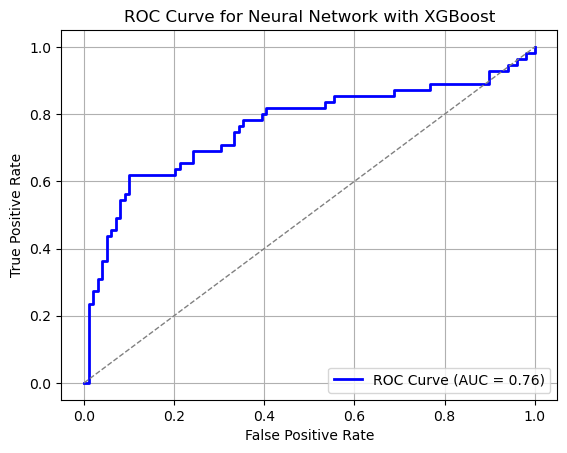

In [19]:
from sklearn.metrics import roc_curve, auc

# ROC AUC Plot
# Use predicted probabilities for the positive class (1)
y_pred_prob = xgb_model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Neural Network with XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()